Data Processing


In [ ]:
# Imports
import numpy as np
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
from sklearn.ensemble import RandomForestRegressor #Regression Baseline Model
from sklearn.metrics import mean_squared_error 
import time
import seaborn as sb

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import csv
import pandas as pd


# Authenticate 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local colab directory to store the data
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

file_list = drive.ListFile(
    {'q': "'1kMVQXJyntpLwmd90hKM6iA3ERbYlSWWE' in parents"}).GetList()

file_name_list = []

for file in file_list:
  # Create & download by id
  file_name = os.path.join(local_download_path, file['title'])
  file_ = drive.CreateFile({'id': file['id']})
  file_.GetContentFile(file_name)
  file_name_list.append(file_name)

df = pd.concat((pd.read_csv(file) for file in file_name_list))

In [ ]:
# Data Loader
def get_data_loader(trainset, batch_size):
  trainset = torch.from_numpy(trainset)
  relevant_indices = list(range(0,len(trainset)))
  np.random.seed(50)
  np.random.shuffle(relevant_indices)
  split = int(len(relevant_indices) * 0.6) #split at 60%
  split2 = int(len(relevant_indices) * 0.9) #split at 90%

  # split into training and validation indices
  relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split], relevant_indices[split:split2], relevant_indices[split2:]  
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            num_workers=1, sampler=val_sampler)

  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            num_workers=1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

Regression

In [ ]:
# Data Processing - Regression Specific

#all_headers = ["LEAGUE","NAME","DY+/-","PLAYER ID","POS","SEASON","GP","EV P1/GP","PP P1/GP",
#           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
#           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
#           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
#           "OFF EV GA","eTOI/GP","P1/e60","DOB","AGE SEPT 15","AGE DEC 31","#","TEAM","HT",
#           "SHOOTS","DRAFT YEAR","NHL DRAFT","DRAFT TEAM","NHL TEAM","HEATMAP"]

# Headers which will be used by regression model as determined by regression correlation heatmap
# 'SEASON' used as a part of ranking mechanism; 'NHL DRAFT' is the target; the other 20 headers are input variables.
relevant_headers = ['SEASON','EV P1/GP', 'PP P1/GP', 'P1/GP', 'EV G', 'EV A1', 
                    'EV A2', 'EV P1', 'PP G', 'PP A1', 'PP A2', 'PP P1',
                    'TG', 'TP1', 'TP', 'TP/GP', 'EV GF', 'EV GF%', 'EV GF%Rel',
                    'eTOI/GP', 'P1/e60', 'NHL DRAFT']

data = df[relevant_headers]

pd.set_option('mode.chained_assignment', None)    #clear warnings

# extract draft position
data["NHL DRAFT"] = data["NHL DRAFT"].str[-4:]
data["NHL DRAFT"] = data["NHL DRAFT"].str.extract('(\d+)', expand=False)

#make sure numeric headers are not strings (clean up by removing spaces)
numeric_headers = ['SEASON','EV P1/GP', 'PP P1/GP', 'P1/GP', 'EV G', 'EV A1', 
                    'EV A2', 'EV P1', 'PP G', 'PP A1', 'PP A2', 'PP P1',
                    'TG', 'TP1', 'TP', 'TP/GP', 'EV GF', 'EV GF%', 'EV GF%Rel',
                    'eTOI/GP', 'P1/e60', 'NHL DRAFT']

data[numeric_headers] = data[numeric_headers].replace({' ':''}, regex=True)
data[numeric_headers] = data[numeric_headers].astype(float)

pd.set_option('mode.chained_assignment', 'warn')    #turn warnings back on

data = pd.get_dummies(data)

# Drafted: 0 - undrafted, 1 - drafted
data.loc[data["NHL DRAFT"].isnull(), "DRAFTED"] = 0 
data.loc[data["NHL DRAFT"].notnull(), "DRAFTED"] = 1 
data[:3]

,SEASON,EV P1/GP,PP P1/GP,P1/GP,EV G,EV A1,EV A2,EV P1,PP G,PP A1,PP A2,PP P1,TG,TP1,TP,TP/GP,EV GF,EV GF%,EV GF%Rel,eTOI/GP,P1/e60,NHL DRAFT,DRAFTED
0,2019.0,0.6471,0.2353,0.9118,25.0,19.0,15.0,44.0,8.0,8.0,7.0,16.0,34.0,62.0,84.0,1.2353,80.0,63.49,9.21,19.24,2.8435,7.0,1.0
1,2019.0,0.5968,0.2419,0.8871,21.0,16.0,7.0,37.0,3.0,12.0,11.0,15.0,25.0,55.0,73.0,1.1774,63.0,57.80,0.27,18.89,2.8182,3.0,1.0
2,2019.0,0.6212,0.2576,0.8788,24.0,17.0,13.0,41.0,12.0,5.0,10.0,17.0,36.0,58.0,81.0,1.2273,78.0,63.93,23.35,19.84,2.6582,29.0,1.0


In [ ]:
# Regression Ranking Mechanism

new_headers = []

for i, header in enumerate(data.keys()):
    new_headers.append(header)

data_drafted = data[new_headers].dropna()     # new dataset with only drafted players
new_headers.pop(0)
new_headers.pop(-1)

#dataset for ranking
ranking_data = data_drafted[new_headers].values.astype(np.float32)
ranking_labels = data_drafted[["SEASON","NHL DRAFT"]].values.astype(np.float32)
years = range(2008, 2020)
new_headers.append("NHL DRAFT")

ranking_trainset = np.array(data_drafted[new_headers].astype(np.float32)) # change

# take first element for sort
def takeFirst(elem):
    return elem[0]

sorting = []
for x in years:
  lst = [[player[-1], i] for i, player in enumerate(ranking_labels) if player[0] == x ]
  lst.sort(key=takeFirst)
  sorted = [[i + 1,player[-1]] for i, player in enumerate(lst)]
  sorting += sorted
for i in sorting:
  ranking_trainset[i[1],-1] = i[0]

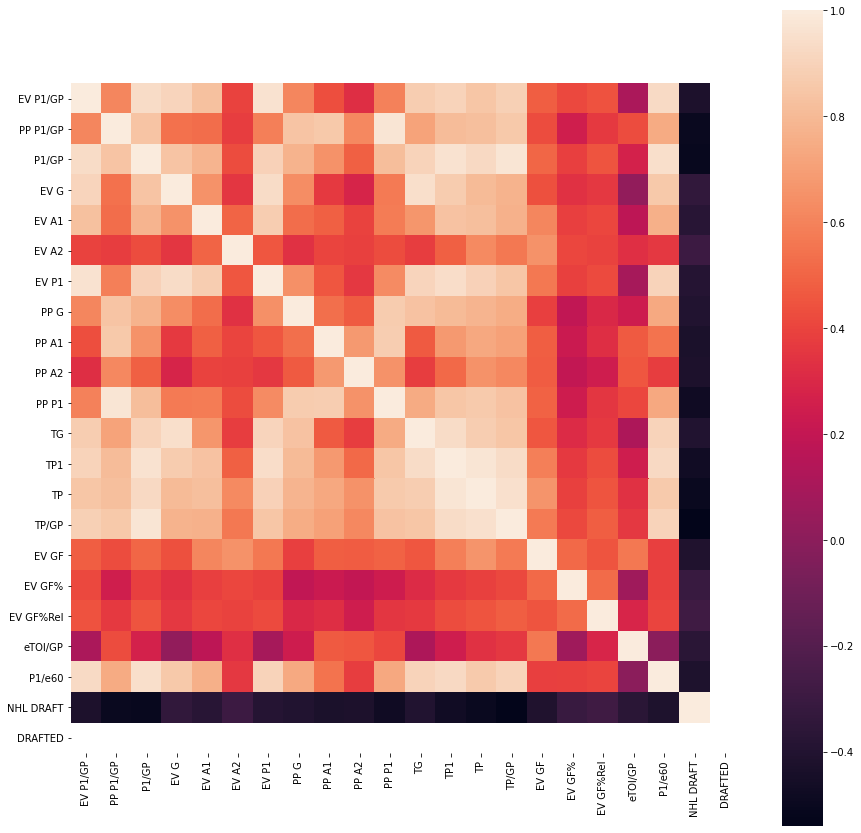

In [ ]:
# Variable Correlation Heatmap for Regression.
data_copy = data_drafted.copy()
first_correlations = data_copy.corr()
for row in first_correlations.axes[0]:
  if (first_correlations.at[row,first_correlations.axes[1][-2]]<0.25 and first_correlations.at[row,first_correlations.axes[1][-2]]>-0.25):
    del data_copy[row]

second_correlations = data_copy.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(second_correlations, vmax = 1, square = True)
plt.show()

In [ ]:
torch.manual_seed(50) # set the random seed

class ANN_regression(nn.Module):
    def __init__(self):
        super(ANN_regression, self).__init__()
        self.layer1 = nn.Linear(20, 2000)
        self.layer2 = nn.Linear(2000, 50)
        self.layer3 = nn.Linear(50, 18)
        self.layer4 = nn.Linear(18, 10)
        self.layer5 = nn.Linear(10,1)
    def forward(self, x):
        activation1 = self.layer1(x)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activation3 = F.relu(activation3)
        activation4 = self.layer4(activation3)
        activation5 = self.layer5(activation4)
        return activation5

In [ ]:
# Regression Evaluation Function
def evaluate_regression(model, loader, criterion):
      
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    correct = 0
    total = 0
    error = 0
    MSE_total = 0
    for i, data in enumerate(loader):
        stats_set = []
        labels_set = []
        for stats in data:
          label = float(stats[-1]) # Last index in stats is label
          labels_set.append(label)
          stats_sub = []
          for j in stats[:-2]:
            stats_sub.append(j)
          stats_set.append(stats_sub)
        labels_set = torch.FloatTensor(labels_set)
        labels_set = labels_set.unsqueeze(1)
        stats_set = torch.FloatTensor(stats_set)
        outputs = model(stats_set)
        loss = criterion(outputs, labels_set) #float
        MSE = mean_squared_error(outputs.detach().numpy(), labels_set.long().detach().numpy())
        corr = (outputs > 0.0).squeeze().long()
        total_err += int(corr.sum())
        total_loss += loss.item()
        MSE_total += MSE
        total_epoch += len(labels_set)
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels_set.view_as(pred)).sum().item()
        total += stats_set.shape[0]
    err = float(total_err) / total_epoch
    acc = correct / total
    loss = float(total_loss) / (i + 1)
    MSE_total = MSE_total/total
    return loss, MSE_total

In [ ]:
# Regression Training Function
def train_net_regression(model, train_loader, val_loader, batch_size=64, learning_rate=0.0001, num_epochs=50):

    torch.manual_seed(50)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs, train_losses, val_losses, train_mses, val_mses = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            stats_set = []
            labels_set = []
            for stats in data:
              label = float(stats[-1]) # Last index in stats is label
              labels_set.append(label)
              stats_sub = []
              for j in stats[:-2]:
                stats_sub.append(j)
              stats_set.append(stats_sub)
            labels_set = torch.FloatTensor(labels_set)
            labels_set = labels_set.unsqueeze(1)
            stats_set = torch.FloatTensor(stats_set)
            out = model(stats_set)
            loss = criterion(out, labels_set) #float
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss, train_MSE = evaluate_regression(model, train_loader, criterion)
        val_loss, val_MSE = evaluate_regression(model, val_loader, criterion)
        print(("Epoch {}: Train loss: {}, Train MSE {} |"+
               "Validation loss: {}, Validation MSE {}").format(
                   epoch + 1,
                   train_loss,
                   train_MSE,
                   val_loss,
                   val_MSE))
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mses.append(train_MSE)
        val_mses.append(val_MSE)
        epochs.append(epoch)

    #Mean-Square Error (MSE)
    plt.title("Accuracy vs. Validation Mean-Square Error (MSE)")
    plt.plot(epochs, train_mses, label="Train")
    plt.plot(epochs, val_mses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    #plt.ylim(0,25)
    plt.legend(loc='best')
    plt.show()

    #Loss
    plt.title("Accuracy vs. Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.ylim(0,5)
    plt.legend(loc='best')
    plt.show()

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader = get_data_loader(ranking_trainset, batch_size)

Epoch 1: Train loss: 2013.4948608398438, Train MSE 34.41871599420658 |Validation loss: 2209.7840087890627, Validation MSE 37.83876770839605
Epoch 2: Train loss: 1828.5166870117187, Train MSE 31.256695956633404 |Validation loss: 2011.4342041015625, Validation MSE 34.4423662196558
Epoch 3: Train loss: 1575.1311279296874, Train MSE 26.925318079904216 |Validation loss: 1776.8326416015625, Validation MSE 30.425216123343382
Epoch 4: Train loss: 1408.95078125, Train MSE 24.08462831686906 |Validation loss: 1503.697314453125, Validation MSE 25.74824233089464
Epoch 5: Train loss: 1205.648858642578, Train MSE 20.60938221615521 |Validation loss: 1290.2255615234376, Validation MSE 22.092903156115337
Epoch 6: Train loss: 1183.1831787109375, Train MSE 20.225353375884378 |Validation loss: 1139.9379638671876, Validation MSE 19.519485705252485
Epoch 7: Train loss: 1030.5656127929688, Train MSE 17.616506208042995 |Validation loss: 1070.159912109375, Validation MSE 18.324655938905543
Epoch 8: Train loss: 

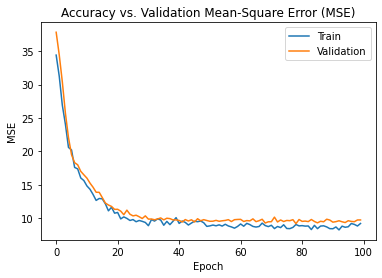

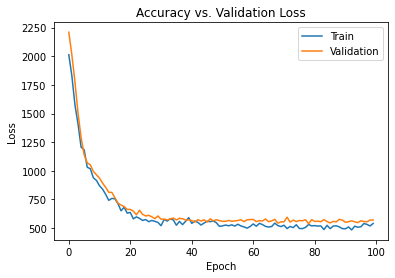

In [ ]:
net_reg = ANN_regression()
train_net_regression(net_reg,train_loader,val_loader,batch_size, learning_rate = 0.0001, num_epochs = 100)

In [ ]:
evaluate_regression(net_reg, test_loader, nn.MSELoss())

(579.2388305664062, 11.821199870447245)

Random Forest Regressor Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def regression_baseline_model(num_iterations):
  best_MSE = 0
  best_iter = 0
  total_MSE = 0
  for iters in range(1,num_iterations+1):
    regression_model = RandomForestRegressor()
    stats = ranking_trainset[:,:-2]
    actual_draft_position = ranking_trainset[:,-1]

    regression_model.fit(stats,actual_draft_position)
    draft_position_prediction = regression_model.predict(stats)
    MSE = mean_squared_error(draft_position_prediction, actual_draft_position)

    if (best_MSE == 0):
      best_MSE = MSE
      best_iter = iter
    elif (MSE<best_MSE):
      best_MSE = MSE
      best_iter = iters
    
    total_MSE += MSE
  
  print ("The best MSE is", best_MSE, "which occurred at iteration", best_iter)
  print ("The average MSE is", total_MSE/num_iterations)

In [ ]:
regression_baseline_model(50)

Classification

In [ ]:
# Data Processing
relevant_headers = ["SEASON", "LEAGUE","POS","GP","EV P1/GP","PP P1/GP",
           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
           "OFF EV GA","eTOI/GP","P1/e60","AGE DEC 31","NHL DRAFT"] 

data = df[relevant_headers]

# extract draft position
data["NHL DRAFT"] = data["NHL DRAFT"].str[-4:]
data["NHL DRAFT"] = data["NHL DRAFT"].str.extract('(\d+)', expand=False)

numeric_headers = ["SEASON", "GP","EV P1/GP","PP P1/GP",
           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
           "OFF EV GA","eTOI/GP","P1/e60","AGE DEC 31","NHL DRAFT"]

data[numeric_headers] = data[numeric_headers].replace({' ':''}, regex=True)
data[numeric_headers] = data[numeric_headers].astype(float)

pd.set_option('mode.chained_assignment', 'warn')    #turn warnings back on

data = pd.get_dummies(data)
# Drafted: 0 - undrafted, 1 - drafted
data.loc[data["NHL DRAFT"].isnull(), "DRAFTED"] = 0 
data.loc[data["NHL DRAFT"].notnull(), "DRAFTED"] = 1 
data[:30]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,SEASON,GP,EV P1/GP,PP P1/GP,P1/GP,EV G,EV A1,EV A2,EV P1,PP G,PP A1,PP A2,PP P1,SH G,SH A1,SH A2,EV S,EV S%,PP S%,PP S,TS,S%,TG,TP1,TP,TP/GP,TS/GP,EV%,Goals/P1,EV GF,EV GA,EV GF%,EV GF%Rel,OFF EV GF,OFF EV GA,eTOI/GP,P1/e60,AGE DEC 31,NHL DRAFT,LEAGUE_OHL,LEAGUE_QMJHL,LEAGUE_WHL,POS_D,POS_F,DRAFTED
0,2019.0,68.0,0.6471,0.2353,0.9118,25.0,19.0,15.0,44.0,8.0,8.0,7.0,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,62.0,84.0,1.2353,0.0,73.33,55.00,80.0,46.0,63.49,9.21,114.0,96.0,19.24,2.8435,18.89,7.0,0,0,1,0,1,1.0
1,2019.0,62.0,0.5968,0.2419,0.8871,21.0,16.0,7.0,37.0,3.0,12.0,11.0,15.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,55.0,73.0,1.1774,0.0,71.15,46.15,63.0,46.0,57.80,0.27,107.0,79.0,18.89,2.8182,18.94,3.0,0,0,1,0,1,1.0
2,2019.0,66.0,0.6212,0.2576,0.8788,24.0,17.0,13.0,41.0,12.0,5.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,58.0,81.0,1.2273,0.0,70.69,62.07,78.0,44.0,63.93,23.35,69.0,101.0,19.84,2.6582,18.59,29.0,0,0,1,0,1,1.0
3,2019.0,66.0,0.3939,0.3636,0.8030,16.0,10.0,6.0,26.0,17.0,7.0,4.0,24.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,53.0,63.0,0.9545,0.0,52.00,66.00,41.0,41.0,50.00,10.51,62.0,95.0,18.28,2.6361,19.09,27.0,0,0,1,0,1,1.0
4,2019.0,64.0,0.5000,0.2656,0.7656,11.0,21.0,10.0,32.0,8.0,9.0,9.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,49.0,68.0,1.0625,0.0,65.31,38.78,50.0,90.0,35.71,-0.70,71.0,124.0,20.50,2.2403,18.93,17.0,0,0,1,0,1,1.0
5,2019.0,68.0,0.5147,0.2206,0.7353,24.0,11.0,7.0,35.0,8.0,7.0,5.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,50.0,62.0,0.9118,0.0,70.00,64.00,60.0,39.0,60.61,9.09,119.0,112.0,16.29,2.7090,18.64,75.0,0,0,1,0,1,1.0
6,2019.0,67.0,0.4179,0.2687,0.7015,18.0,10.0,14.0,28.0,7.0,11.0,10.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,47.0,71.0,1.0597,0.0,60.87,54.35,76.0,39.0,66.09,10.46,84.0,67.0,23.48,1.7929,18.55,4.0,0,0,1,1,0,1.0
7,2019.0,31.0,0.4516,0.1613,0.6452,7.0,7.0,4.0,14.0,3.0,2.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,20.0,26.0,0.8387,0.0,73.68,52.63,24.0,28.0,46.15,0.87,48.0,58.0,17.42,2.2217,19.17,55.0,0,0,1,0,1,1.0
8,2019.0,68.0,0.4559,0.1471,0.6324,17.0,14.0,11.0,31.0,4.0,6.0,5.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,43.0,59.0,0.8676,0.0,75.61,51.22,60.0,45.0,57.14,3.93,116.0,102.0,17.46,2.1735,18.86,147.0,0,0,1,0,1,1.0
9,2019.0,47.0,0.4255,0.1489,0.5745,5.0,15.0,9.0,20.0,3.0,4.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,27.0,40.0,0.8511,0.0,74.07,29.63,41.0,30.0,57.75,7.39,70.0,69.0,17.73,1.9440,18.51,136.0,0,0,1,0,1,1.0


In [ ]:
# Dataset for classification
new_headers = []

for i, header in enumerate(data.keys()):
    new_headers.append(header)

data_drafted = data[new_headers].dropna()     # new dataset with only drafted players
new_headers.pop(0) # Remove season
new_headers.pop(-1) # Remove label
new_headers.pop(-6) # Remove draft position

class_data = data[new_headers].values.astype(np.float32)
class_labels = data["DRAFTED"].values.astype(np.float32)
ranking_headers = new_headers.append("DRAFTED")
class_trainset = np.array(data[new_headers].astype(np.float32))

test_trainset = np.array(data_drafted[new_headers].astype(np.float32))

In [ ]:
# Balance dataset
add_data = data_drafted[new_headers]
class_trainset = data[new_headers]
add_trainset = pd.concat(add_data for i in range(3))
add = [add_trainset, class_trainset]
class_trainset = pd.concat(add)
class_trainset = np.array(class_trainset.values.astype(np.float32))

In [ ]:
# Classification Architecture
class ANN_class(nn.Module):
    def __init__(self,layers):
        super(ANN_class, self).__init__()
        self.layer1 = nn.Linear(layers, 10) 
        self.layer2 = nn.Linear(10,2)
    def forward(self, x):
        activation1 = self.layer1(x)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

In [ ]:
# Evaluation for classification model
def evaluate_class(model, loader, criterion):
  
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    correct = 0
    total = 0
    error = 0
    for i, data in enumerate(loader):
        stats_set = []
        labels_set = []
        for stats in data:
          # Last index in stats is label
          label = float(stats[-1])
          labels_set.append(label)
          stats_sub = []
          for j in stats[:-1]:
            stats_sub.append(j)
          stats_set.append(stats_sub)
        labels_set = torch.FloatTensor(labels_set)
        stats_set = torch.FloatTensor(stats_set)
        outputs = model(stats_set)
        loss = criterion(outputs, labels_set.long())#float
        total_loss += loss.item()
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels_set.view_as(pred)).sum().item()
        total += stats_set.shape[0]
    acc = correct / total
    loss = float(total_loss) / (i + 1)
    return acc, loss

In [ ]:
# Training for classification model
def train_net_class(model, train_loader, val_loader, batch_size=64, learning_rate=0.0001, num_epochs=50):

    torch.manual_seed(50)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    epochs, train_losses, val_losses, train_accs, val_accs = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            stats_set = []
            labels_set = []
            for stats in data:
              # Last index in stats is label
              label = float(stats[-1])
              labels_set.append(label)
              stats_sub = []
              for j in stats[:-1]:
                stats_sub.append(j)
              stats_set.append(stats_sub)
            labels_set = torch.FloatTensor(labels_set)
            stats_set = torch.FloatTensor(stats_set)
            out = model(stats_set)
            loss = criterion(out, labels_set.long()) #float
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        train_acc, train_loss = evaluate_class(model, train_loader, criterion)
        val_acc, val_loss = evaluate_class(model, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc,
                   train_loss,
                   val_acc,
                   val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        epochs.append(epoch)

    plt.title("Train vs Validation Accuracy")
    plt.plot(epochs, train_accs, label="Train")
    plt.plot(epochs, val_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = get_data_loader(class_trainset, batch_size)

In [ ]:
net_class = ANN_class(layers = 42)
train_net_class(net_class,train_loader,val_loader,batch_size, learning_rate=0.0001, num_epochs=50)

tensor(1.8773, grad_fn=<NllLossBackward>)
tensor(2.1873, grad_fn=<NllLossBackward>)
tensor(1.4469, grad_fn=<NllLossBackward>)
tensor(1.5830, grad_fn=<NllLossBackward>)
tensor(1.8623, grad_fn=<NllLossBackward>)
tensor(2.0889, grad_fn=<NllLossBackward>)
tensor(1.2183, grad_fn=<NllLossBackward>)
tensor(1.6833, grad_fn=<NllLossBackward>)
tensor(1.5398, grad_fn=<NllLossBackward>)
tensor(1.2717, grad_fn=<NllLossBackward>)
tensor(2.4128, grad_fn=<NllLossBackward>)
tensor(2.1035, grad_fn=<NllLossBackward>)
tensor(0.9860, grad_fn=<NllLossBackward>)
tensor(2.4295, grad_fn=<NllLossBackward>)
tensor(1.1572, grad_fn=<NllLossBackward>)
tensor(1.3424, grad_fn=<NllLossBackward>)
tensor(1.6055, grad_fn=<NllLossBackward>)
tensor(1.0547, grad_fn=<NllLossBackward>)
tensor(1.6712, grad_fn=<NllLossBackward>)
tensor(1.4002, grad_fn=<NllLossBackward>)
tensor(1.4311, grad_fn=<NllLossBackward>)
tensor(1.8263, grad_fn=<NllLossBackward>)
tensor(1.4376, grad_fn=<NllLossBackward>)
tensor(1.7083, grad_fn=<NllLossBac

KeyboardInterrupt: ignored

In [ ]:
# Holdout data from trainset
evaluate_class(net_class,test_loader, criterion = nn.CrossEntropyLoss())

(0.7907303370786517, 0.45995628056318866)

K-Means Clustering Baseline Model

In [ ]:
#K-Means Clustering
from sklearn.cluster import KMeans

#Define the important, clusterable features from the main dataframe
baseline_data_copy = data.copy()
features = []
features.extend(list(baseline_data_copy.columns[:-7]))
features.extend(list(baseline_data_copy.columns[-5:]))

#Build the K-Means Clustering model and the comparison between predicted and actual values
#Note that sometimes the prediction labels can be swapped in K-Means clustering (i.e. drafted predictions are sometimes marked as 0 when it should be marked as 1 and vice-versa for undrafted predictions).
#Predictions are still made correctly, but there is incompatability with the labels for the actual result resulting in a direct inversion of the confusion matrix results.
#If the prediction and actual labels are incompatible, re-run until they are. 
cleaned_data = baseline_data_copy[features]
kmeans = KMeans(n_clusters = 2)
cleaned_data['drafted_prediction'] = kmeans.fit_predict(cleaned_data) 
cleaned_data['NHL Drafted'] = baseline_data_copy['DRAFTED'].astype('int64')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


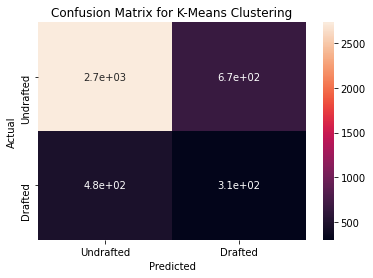



Confusion Matrix Results

True Positives: 306 Percentage: 0.07306590257879657
False Positives: 669 Percentage: 0.15974212034383956
True Negatives: 2728 Percentage: 0.6513849092645654
False Negatives: 485 Percentage: 0.11580706781279847
Accuracy: 3034 Percentage: 0.724450811843362


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


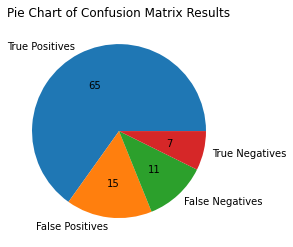

In [ ]:
#Confusion Matrix
import seaborn as sn
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(cleaned_data['drafted_prediction'], cleaned_data['NHL Drafted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, xticklabels=["Undrafted","Drafted"], yticklabels=["Undrafted", "Drafted"])
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()

#Report Confusion Matrix Results
print ("\n\nConfusion Matrix Results\n")
print ("True Positives:", confusion_matrix[1][1], "Percentage:", confusion_matrix[1][1]/len(baseline_data_copy))
print ("False Positives:", confusion_matrix[1][0], "Percentage:", confusion_matrix[1][0]/len(baseline_data_copy))
print ("True Negatives:", confusion_matrix[0][0], "Percentage:", confusion_matrix[0][0]/len(baseline_data_copy))
print ("False Negatives:", confusion_matrix[0][1], "Percentage:", confusion_matrix[0][1]/len(baseline_data_copy))
print ("Accuracy:", confusion_matrix[0][0] + confusion_matrix[1][1], "Percentage:", (confusion_matrix[0][0] + confusion_matrix[1][1])/len(baseline_data_copy))

#Pie-chart visual of results.
confusion_matrix_array = confusion_matrix.to_numpy().reshape(1,4)
pie_labels = ["True Positives", "False Positives", "False Negatives", "True Negatives"]
plt.pie(confusion_matrix_array, labels=pie_labels, autopct=int)
plt.title("Pie Chart of Confusion Matrix Results")
plt.show()

2020 Data (New data)

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import csv
import pandas as pd
import torch
import torch.nn as nn

# Authenticate 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local colab directory to store the data
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

file_list = drive.ListFile(
    {'q': "'1AXhCoXI5XbBhBHeT2Zr1jZmVNGoZw5GS' in parents"}).GetList()

file_name_list = []

for file in file_list:
  # Create & download by id
  file_name = os.path.join(local_download_path, file['title'])
  file_ = drive.CreateFile({'id': file['id']})
  file_.GetContentFile(file_name)
  file_name_list.append(file_name)

df_2020 = pd.concat((pd.read_csv(file) for file in file_name_list))

In [ ]:
# Regression
relevant_headers = ['NAME','EV P1/GP', 'PP P1/GP', 'P1/GP', 'EV G', 'EV A1', 
                    'EV A2', 'EV P1', 'PP G', 'PP A1', 'PP A2', 'PP P1', 
                    'TG', 'TP1', 'TP', 'TP/GP', 'EV GF', 'EV GF%', 'EV GF%Rel', 
                    'eTOI/GP', 'P1/e60']

data = df_2020[relevant_headers]

pd.set_option('mode.chained_assignment', None)    #clear warnings

numeric_headers = ['EV P1/GP', 'PP P1/GP', 'P1/GP', 'EV G', 'EV A1', 
                    'EV A2', 'EV P1', 'PP G', 'PP A1', 'PP A2', 'PP P1', 
                    'TG', 'TP1', 'TP', 'TP/GP', 'EV GF', 'EV GF%', 'EV GF%Rel', 
                    'eTOI/GP', 'P1/e60']
                    
data[numeric_headers] = data[numeric_headers].replace({' ':''}, regex=True)
data[numeric_headers] = data[numeric_headers].astype(float)

pd.set_option('mode.chained_assignment', 'warn')    #turn warnings back on

reg_testset_2020 = torch.from_numpy(np.array(data[numeric_headers].astype(np.float32)))
reg_loader_2020 = torch.utils.data.DataLoader(reg_testset_2020, batch_size=batch_size,
                                            num_workers=1)
names = np.array(data['NAME'])
print(reg_testset_2020[1])
print(names[1])

tensor([ 0.6316,  0.4561,  1.1404, 20.0000, 16.0000,  8.0000, 36.0000, 15.0000,
        11.0000, 12.0000, 26.0000, 38.0000, 65.0000, 86.0000,  1.5088, 67.0000,
        62.6200,  4.3300, 17.5100,  3.9081])
Connor Zary


In [ ]:
# Classification
relevant_headers = ["LEAGUE","POS","GP","EV P1/GP","PP P1/GP",
           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
           "OFF EV GA","eTOI/GP","P1/e60","AGE DEC 31"] 

data = df_2020[relevant_headers]

pd.set_option('mode.chained_assignment', None)    #clear warnings

numeric_headers = ["GP","EV P1/GP","PP P1/GP",
           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
           "OFF EV GA","eTOI/GP","P1/e60","AGE DEC 31"] 

data[numeric_headers] = data[numeric_headers].replace({' ':''}, regex=True)
data[numeric_headers] = data[numeric_headers].astype(float)

pd.set_option('mode.chained_assignment', 'warn')    #turn warnings back on

data = pd.get_dummies(data)

class_testset_2020 = torch.from_numpy(np.array(data.astype(np.float32)))
names = np.array(df_2020['NAME'])

In [ ]:
#Regression output

# take first element for sort
def takeFirst(elem):
    return elem[0]

def reg_output_2020(model, loader, names):
  out_list = []
  for i,data in enumerate(loader):
        stats_set = []
        for stats in data:
          stats_sub = []
          for j in stats[:]:
            stats_sub.append(j)
          stats_set.append(stats_sub)
        stats_set = torch.FloatTensor(stats_set)
        out = model(stats_set)
        for i in out:
          out_list.append(i)
  lst = [[rank, i] for i, rank in enumerate(out_list)]
  lst.sort(key=takeFirst)
  sorted = [[i + 1, player[-1]] for i, player in enumerate(lst)]
  output = [names[i[-1]] for i in sorted]
  output = [[i+1, x] for i,x in enumerate(output)]
  return output

In [ ]:
# Classification Output
def class_output_2020(model, testset, names):
  out = model(testset)
  labels = [torch.argmax(i) for i in out]
  drafted = [player for i,player in enumerate(names) if labels[i] == 1]
  undrafted = [player for i,player in enumerate(names) if labels[i] == 0]
  return drafted, undrafted

In [ ]:
# Classification Model Prediction
drafted, undrafted = class_output_2020(net_class, class_testset_2020, names)
print ("Drafted \n", np.transpose(drafted))
print ("Undrafted \n", np.transpose(undrafted))

Drafted 
 ['Seth Jarvis' 'Connor Zary' 'Tristen Robins' 'Pavel Novak' 'Ridly Greig'
 'Ozzy Wiesblatt' 'Kyle Crnkovic' 'Connor McClennon' 'Justin Sourdif'
 'Jake Neighbours' 'Jack Finley' 'Cross Hanas' 'Lukas Svejkovsky'
 'Owen Pederson' 'Michal Gut' 'Robbie Fromm-Delorme' 'Ben King'
 'Josh Pillar' 'Simon Knak' 'Cole Shepard' 'Keanu Derungs'
 'Braden Schneider' 'Simon Kubicek' 'Kaiden Guhle' 'Kasper Puutio'
 'Ryker Evans' 'Luke Prokop' 'Christoffer Sedoff' 'Ronan Seeley'
 'Danila Palivko' 'Alexis Lafreniere' 'Mavrik Bourque' 'Dawson Mercer'
 'Ryan Francis' 'William Dufour' 'Hendrix Lapierre' 'Brady Burns'
 'Vasili Ponomaryov' 'Patrick Guay' 'William Villeneuve' 'Jeremie Poirier'
 'Charles Beaudoin' 'Adam Raska' 'Theo Rochette' 'Senna Peeters'
 'Valentin Demchenko' 'Cole Cormier' 'Thimo Nickl' 'Lukas Cormier'
 'Jacob Dion' 'Maxim Bykov' 'Josh Lawrence' 'Raivis Ansons'
 'Miguel Tourigny' 'Elliot Desnoyers' 'Philippe Daoust' 'Justin Barron'
 'Charlie Desroches' 'Charles-Antoine Element' 'C

In [ ]:
# Regression Model Prediction
reg_output_2020(net_reg, reg_loader_2020, names)

[[1, 'Jacob Perreault'],
 [2, 'Tyson Foerster'],
 [3, 'Alexis Lafreniere'],
 [4, 'Connor Zary'],
 [5, 'Marco Rossi'],
 [6, 'Cole Perfetti'],
 [7, 'Jack Quinn'],
 [8, 'Tristen Robins'],
 [9, 'Mavrik Bourque'],
 [10, 'Seth Jarvis'],
 [11, 'Brandon Coe'],
 [12, 'Quinton Byfield'],
 [13, 'Kyle Crnkovic'],
 [14, 'Brady Burns'],
 [15, 'Zayde Wisdom'],
 [16, 'Pavel Novak'],
 [17, 'James Hardie'],
 [18, 'Aiden Bulych'],
 [19, 'Jacob Dion'],
 [20, 'Rory Kerins'],
 [21, 'Ben King'],
 [22, 'Jeremie Poirier'],
 [23, 'William Villeneuve'],
 [24, 'Ridly Greig'],
 [25, 'Ozzy Wiesblatt'],
 [26, 'Tyler Tullio'],
 [27, 'Jaromir Pytlik'],
 [28, 'Jake Uberti'],
 [29, 'Landon Roberts'],
 [30, 'Ryker Evans'],
 [31, 'Josh Lawrence'],
 [32, 'Owen Pederson'],
 [33, 'Noah Delemont'],
 [34, 'Thimo Nickl'],
 [35, 'Raivis Ansons'],
 [36, 'Payton Mount'],
 [37, 'Vitali Pinchuk'],
 [38, 'Christoffer Sedoff'],
 [39, 'Anthony Tabak'],
 [40, 'Dawson Stairs'],
 [41, 'Martin Chromiak'],
 [42, "Ryan O'Rourke"],
 [43, 'Lle

In [ ]:
##### Regression Qualitative Results #####

batch_size = 10
train_loader, val_loader, test_loader = get_data_loader(ranking_trainset, batch_size)
output = []
np.random.seed(50)

for data in val_loader:
  stats_set = []
  labels_set = []
  for stats in data:
    label = float(stats[-1]) # Last index in stats is label
    labels_set.append(label)
    stats_sub = []
    for j in stats[:-2]:
      stats_sub.append(j)
    stats_set.append(stats_sub)
  labels_set = torch.FloatTensor(labels_set)
  labels_set = labels_set.unsqueeze(1)
  stats_set = torch.FloatTensor(stats_set)
  out = net_reg(stats_set)
  for i, pred in enumerate(out):
    #output.append(['Actual:'+str(labels_set[i].numpy()[0]),'Predicted:'+str(pred.detach().numpy()[0])])
    output.append([str(labels_set[i].numpy()[0]),str(pred.detach().numpy()[0])])
    for stats in stats_set[i]:
      output[i].append(float(stats.numpy()))
  break

reg_headers = ['Actual','Predicted','EV P1/GP', 'PP P1/GP', 'P1/GP', 'EV G', 'EV A1', 
                    'EV A2', 'EV P1', 'PP G', 'PP A1', 'PP A2', 'PP P1', 
                    'TG', 'TP1', 'TP', 'TP/GP', 'EV GF', 'EV GF%', 'EV GF%Rel', 
                    'eTOI/GP', 'P1/e60']

from google.colab import drive
drive.mount('/content/gdrive')

import csv

with open('/content/gdrive/My Drive/reg_val_demo.csv','w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(reg_headers)
    for i in output:
      filewriter.writerow(i)

df = (pd.read_csv('/content/gdrive/My Drive/reg_val_demo.csv'))
df[:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Actual,Predicted,EV P1/GP,PP P1/GP,P1/GP,EV G,EV A1,EV A2,EV P1,PP G,PP A1,PP A2,PP P1,TG,TP1,TP,TP/GP,EV GF,EV GF%,EV GF%Rel,eTOI/GP,P1/e60
0,3.0,4.186896,0.8413,0.6349,1.5397,27.0,26.0,14.0,53.0,15.0,25.0,15.0,40.0,44.0,97.0,126.0,2.0000,74.0,69.809998,21.940001,19.610001,4.7108
1,35.0,76.875680,0.0333,0.0000,0.0333,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0333,2.0,22.219999,-40.889999,8.850000,0.2260
2,49.0,33.854950,0.4000,0.2500,0.6500,20.0,4.0,3.0,24.0,7.0,8.0,5.0,15.0,27.0,39.0,47.0,0.7833,35.0,43.209999,-9.230000,15.680000,2.4877
3,4.0,18.132566,0.7895,0.4035,1.2456,25.0,20.0,14.0,45.0,10.0,13.0,6.0,23.0,36.0,71.0,91.0,1.5965,79.0,63.709999,10.860000,19.059999,3.9212
4,33.0,42.666367,0.4068,0.1864,0.6102,16.0,8.0,5.0,24.0,8.0,3.0,2.0,11.0,25.0,36.0,43.0,0.7288,43.0,51.189999,-3.390000,15.800000,2.3173
5,2.0,18.446302,0.9388,0.4694,1.5510,30.0,16.0,11.0,46.0,7.0,16.0,17.0,23.0,41.0,76.0,105.0,2.1429,74.0,71.839996,7.510000,21.040001,4.4226
6,3.0,37.259950,0.2459,0.2459,0.4918,10.0,5.0,18.0,15.0,4.0,11.0,8.0,15.0,14.0,30.0,56.0,0.9180,81.0,68.070000,2.290000,18.940001,1.5581
7,53.0,48.557663,0.1475,0.0820,0.2295,3.0,6.0,8.0,9.0,3.0,2.0,6.0,5.0,6.0,14.0,28.0,0.4590,42.0,52.500000,-1.940000,17.459999,0.7888
8,82.0,17.964832,0.3571,0.2714,0.6286,14.0,11.0,8.0,25.0,10.0,9.0,2.0,19.0,24.0,44.0,54.0,0.7714,56.0,45.529999,8.610000,15.590000,2.4198
9,45.0,46.646930,0.2593,0.0926,0.3704,7.0,7.0,10.0,14.0,1.0,4.0,5.0,5.0,9.0,20.0,35.0,0.6481,52.0,53.060001,-3.920000,18.120001,1.2266


In [ ]:
##### Classification Qualitative Results #####

batch_size = 10
train_loader, val_loader, test_loader = get_data_loader(class_trainset, batch_size)
output = []
np.random.seed(50)

for data in test_loader:
  stats_set = []
  labels_set = []
  for stats in data:
    label = float(stats[-2]) # Last index in stats is label
    labels_set.append(label)
    stats_sub = []
    for j in stats[:-1]:
      stats_sub.append(j)
    stats_set.append(stats_sub)
  labels_set = torch.FloatTensor(labels_set)
  labels_set = labels_set.unsqueeze(1)
  stats_set = torch.FloatTensor(stats_set)
  out = net_class(stats_set)
  out_label = [torch.argmax(i) for i in out]

  for i, pred in enumerate(out_label):
    #output.append(['Actual:'+str(labels_set[i].numpy()[0]),'Predicted:'+str(pred.detach().numpy()[0])])
    output.append([str(labels_set[i].numpy()[0]),str(pred.detach().numpy())])
    for stats in stats_set[i]:
      output[i].append(float(stats.numpy()))
  break

class_headers = ['Actual','Predicted',"GP","EV P1/GP","PP P1/GP",
           "P1/GP","EV G","EV A1","EV A2","EV P1","PP G","PP A1","PP A2","PP P1","SH G",
           "SH A1","SH A2","EV S","EV S%","PP S%","PP S","TS","S%","TG","TP1","TP","TP/GP",
           "TS/GP","EV%","Goals/P1","EV GF","EV GA","EV GF%","EV GF%Rel","OFF EV GF",
           "OFF EV GA","eTOI/GP","P1/e60","AGE DEC 31", 
           'LEAGUE_OHL',	'LEAGUE_QMJHL',	'LEAGUE_WHL',	'POS_D',	'POS_F'] 
#class_headers = ['Actual','Predicted']
from google.colab import drive
drive.mount('/content/gdrive')

import csv

with open('/content/gdrive/My Drive/class_test1.csv','w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(class_headers)
    for i in output:
      filewriter.writerow(i)

df = (pd.read_csv('/content/gdrive/My Drive/class_test1.csv'))
df[:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Actual,Predicted,GP,EV P1/GP,PP P1/GP,P1/GP,EV G,EV A1,EV A2,EV P1,PP G,PP A1,PP A2,PP P1,SH G,SH A1,SH A2,EV S,EV S%,PP S%,PP S,TS,S%,TG,TP1,TP,TP/GP,TS/GP,EV%,Goals/P1,EV GF,EV GA,EV GF%,EV GF%Rel,OFF EV GF,OFF EV GA,eTOI/GP,P1/e60,AGE DEC 31,LEAGUE_OHL,LEAGUE_QMJHL,LEAGUE_WHL,POS_D,POS_F
0,1.0,1,67.0,0.4776,0.1493,0.6269,21.0,11.0,6.0,32.0,7.0,3.0,6.0,10.0,0.0,0.0,0.0,137.0,15.33,18.92,37.0,179.0,15.64,28.0,42.0,54.0,0.8060,2.67,76.190002,66.669998,63.0,59.0,51.639999,15.310000,85.0,149.0,17.830000,2.1099,18.879999,1.0,0.0,0.0,0.0,1.0
1,1.0,1,65.0,0.2615,0.0769,0.3692,9.0,8.0,8.0,17.0,5.0,0.0,1.0,5.0,1.0,1.0,0.0,100.0,9.00,22.73,22.0,127.0,11.81,15.0,24.0,33.0,0.5077,1.95,77.269997,63.639999,49.0,28.0,63.639999,4.290000,127.0,87.0,14.770000,1.5003,19.219999,0.0,1.0,0.0,0.0,1.0
2,0.0,0,48.0,0.0417,0.0417,0.0833,1.0,1.0,5.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,2.0,4.0,9.0,0.1875,0.00,50.000000,50.000000,24.0,33.0,42.110001,-12.330000,86.0,72.0,14.980000,0.3337,18.660000,0.0,0.0,1.0,1.0,0.0
3,0.0,0,39.0,0.0513,0.0000,0.0513,1.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,1.0,2.0,8.0,0.2051,0.00,100.000000,50.000000,39.0,21.0,65.000000,-5.490000,86.0,36.0,17.139999,0.1795,18.900000,0.0,0.0,1.0,1.0,0.0
4,0.0,1,71.0,0.1127,0.1831,0.2958,3.0,5.0,3.0,8.0,7.0,6.0,11.0,13.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,10.0,21.0,35.0,0.4930,0.00,38.099998,47.619999,43.0,43.0,50.000000,-11.390000,124.0,78.0,16.160000,1.0983,18.570000,0.0,0.0,1.0,1.0,0.0
5,1.0,1,68.0,0.5294,0.2647,0.7941,20.0,16.0,7.0,36.0,12.0,6.0,4.0,18.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,32.0,54.0,65.0,0.9559,0.00,66.669998,59.259998,67.0,37.0,64.419998,16.200001,95.0,102.0,15.450000,3.0836,19.270000,1.0,0.0,0.0,0.0,1.0
6,1.0,1,70.0,0.5857,0.1857,0.7857,16.0,25.0,12.0,41.0,3.0,10.0,12.0,13.0,1.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,20.0,55.0,79.0,1.1286,0.00,75.930000,35.189999,74.0,59.0,55.639999,14.180000,85.0,120.0,16.110001,2.9271,18.610001,0.0,0.0,1.0,0.0,1.0
7,0.0,1,70.0,0.1429,0.0143,0.1714,3.0,7.0,14.0,10.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,3.0,12.0,26.0,0.3714,0.00,90.910004,27.270000,63.0,32.0,66.320000,17.490000,104.0,109.0,16.209999,0.6344,18.920000,0.0,0.0,1.0,1.0,0.0
8,1.0,1,60.0,0.4167,0.0500,0.4667,12.0,13.0,7.0,25.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0,96.0,12.50,8.33,12.0,109.0,11.93,13.0,28.0,37.0,0.6167,1.82,89.290001,46.430000,49.0,42.0,53.849998,3.110000,103.0,100.0,16.059999,1.7429,18.370001,1.0,0.0,0.0,0.0,1.0
9,1.0,0,61.0,0.0492,0.0000,0.0492,3.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,3.0,3.0,5.0,0.0820,0.00,100.000000,100.000000,7.0,23.0,23.330000,-38.020000,154.0,97.0,9.670000,0.3053,18.980000,0.0,0.0,1.0,0.0,1.0
